# Business objective

Business owners may receive thoushands of customer reviews everyday. It will be too expensive to process these reviews mannually. In my capstone project, I design a deep-learning based model to help business owners to summarize customer reviews automatically.

In [1]:
# import libraries
import torch
import torch.nn as nn
import re           
from bs4 import BeautifulSoup
from torchtext.data import Field, TabularDataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

# Defining the transformer model

I use a transformer model for this capstone project. The transformer model still has the encoder-decoder architecture, but unlikely the previous RNN-based models this new paradigm can take advantage of parallel computing and allows for transfer learning. In this project, my model takes customer review as the input and outputs a short summary. It was trained on a data set that consists of real customer reviews (on fine food products) and summaries from Amazon.com.

In [2]:
# encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length=100):
        super().__init__()
        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device) for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        batch_size, src_len = src.shape
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #print(pos.shape, src.shape)
        src = self.dropout((self.tok_embedding(src)*self.scale)+self.pos_embedding(pos))
        for layer in self.layers:
            src = layer(src, src_mask)
        return src

# encoder
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        _src, _ = self.self_attention(src, src, src, src_mask)
        src = self.self_attn_layer_norm(src+self.dropout(_src))
        
        _src = self.positionwise_feedforward(src)
        src = self.ff_layer_norm(src+self.dropout(_src))
        return src

# encoder
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim//n_heads
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, query, key, value, mask=None):
        
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
                        
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2))/self.scale
        if mask is not None:
            energy = energy.masked_fill(mask==0, -1e10)
        attention = torch.softmax(energy, dim=-1)
        x = torch.matmul(self.dropout(attention), V)
        
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(batch_size, -1, self.hid_dim)
                
        x = self.fc_o(x)
                
        return x, attention

# encoder
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.dropout(torch.relu(self.fc_1(x)))
        x = self.fc_2(x)
        return x

# decoder
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length=100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device) for _ in range(n_layers)])
        self.fc_out = nn.Linear(hid_dim, output_dim)        
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        batch_size, trg_len = trg.shape
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        trg = self.dropout((self.tok_embedding(trg)*self.scale)+self.pos_embedding(pos))
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        output = self.fc_out(trg)
        return output, attention

# decoder
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg = self.self_attn_layer_norm(trg+self.dropout(_trg))
        
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg = self.enc_attn_layer_norm(trg+self.dropout(_trg))
        
        _trg = self.positionwise_feedforward(trg)
        trg = self.ff_layer_norm(trg+self.dropout(_trg))
        return trg, attention

# model
class seq2seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask
    
    def make_trg_mask(self, trg):
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()
        trg_mask = trg_pad_mask & trg_sub_mask
        return trg_mask

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        enc_src = self.encoder(src, src_mask)
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        return output, attention

# Loading the trained model

In [3]:
# create dict
SRC = Field(init_token='<sos>', 
            eos_token='<eos>', 
            batch_first=True)
TRG = Field(init_token='<sos>', 
            eos_token='<eos>', 
            batch_first=True)
data_fields = [('src', SRC), ('trg', TRG)]
train_set = TabularDataset(path='data/train_set.csv',
                           format='csv', skip_header=True,
                           fields=data_fields)
SRC.build_vocab(train_set, min_freq=2)
TRG.build_vocab(train_set, min_freq=2)

In [4]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model instantiation
input_dim = len(SRC.vocab)
output_dim = len(TRG.vocab)
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1
src_pad_idx = SRC.vocab.stoi[SRC.pad_token]
trg_pad_idx = TRG.vocab.stoi[TRG.pad_token]

enc = Encoder(input_dim, hid_dim, enc_layers, enc_heads,
              enc_pf_dim, enc_dropout, device)
dec = Decoder(output_dim, hid_dim, dec_layers, dec_heads,
              dec_pf_dim, dec_dropout, device)
model = seq2seq(enc, dec, src_pad_idx, trg_pad_idx, device).to(device)

In [5]:
# load parameter
model.load_state_dict(torch.load('data/transformer.pt', map_location=torch.device(device)))

<All keys matched successfully>

# Word counts of reviews and summary in the training dataset

In [6]:
train=pd.read_csv('data/train_set.csv')
train = train.dropna()
train.columns = ['Customer review', 'Summary']

In [7]:
train = train.applymap(lambda x: len(x.split()))

Text(0.5, 0.98, 'Word count distriutions')

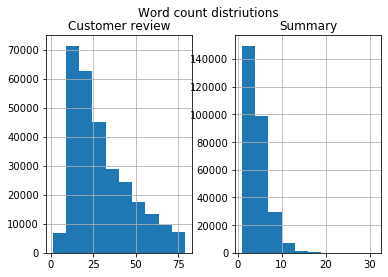

In [8]:
hist = train.hist(bins=10)
plt.suptitle('Word count distriutions')

The above figure compares the distributions of word counts of the original customer reviews and summaries from the training dataset.

# Data preprocessing

To process the raw text of customer reviews, the following data preprocessing steps are performed:
* expanding the contractions (e.g., from "ain't" to "is not")
* removing HTML tags
* converting everything to lowercase
* removing (‘s)
* removing any text inside the parenthesis ( )
* eliminating punctuations and special characters
* removing stopwords

In [9]:
# data cleaning
# contraction dict
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
					   "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                       "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                       "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                       "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                       "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                       "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                       "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                       "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                       "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                       "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                       "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                       "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                       "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                       "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                       "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                       "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                       "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                       "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                       "you're": "you are", "you've": "you have"}

# data cleaning
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, 'lxml').text
    newString = re.sub(r'\([^)]*\)', ' ', newString)
    newString = re.sub('"', ' ', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(' ')])
    newString = re.sub(r"'s\b", ' ', newString)
    newString = re.sub('[^a-zA-Z]', ' ', newString)
    newString = (' '.join([w for w in newString.split()]))
    return newString.strip()

# APP

In [10]:
# inference
def review_summarizer(review, src_field, trg_field, model, device, max_len=20, max_len_rev=100):
    model.eval()
    
    tokens = text_cleaner(review)
    tokens = [src_field.init_token] + tokens.split() + [src_field.eos_token]
    
    src_indexes = [src_field.vocab.stoi[token] for token in tokens][:max_len_rev]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token)
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes][1:-1]
    return ' '.join(trg_tokens), attention

In [11]:
def f(review):
    summary, attention = review_summarizer(review, SRC, TRG, model, device)
    max_attention = torch.max(torch.max(attention, 1)[0], 1)[0].squeeze()\
                    .cpu().detach().numpy()[1:-1]
    mina, maxa = min(max_attention), max(max_attention)
    importance = (max_attention-mina)/(maxa-mina)
    return summary, importance

In [12]:
def getPlot(review, importance):
    tokens = review.split()
    f, ax = plt.subplots(figsize=(20,5))
    plt.bar(tokens, list(importance), color='maroon', width=0.4)
    plt.xticks(rotation=90)
    ax.tick_params(axis='both', which='major', labelsize=20)

# Customer review - replace the example review with your input

In [13]:
review = 'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'
# enter here your own customer review
# review = ''

# Model outputs

In [14]:
summary, importance = f(review)

# The input customer review

In [15]:
print(review)

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


# Machine-generated summary

In [16]:
print(summary)

good food


# How the above summary is determined - the importance of each word in the original review

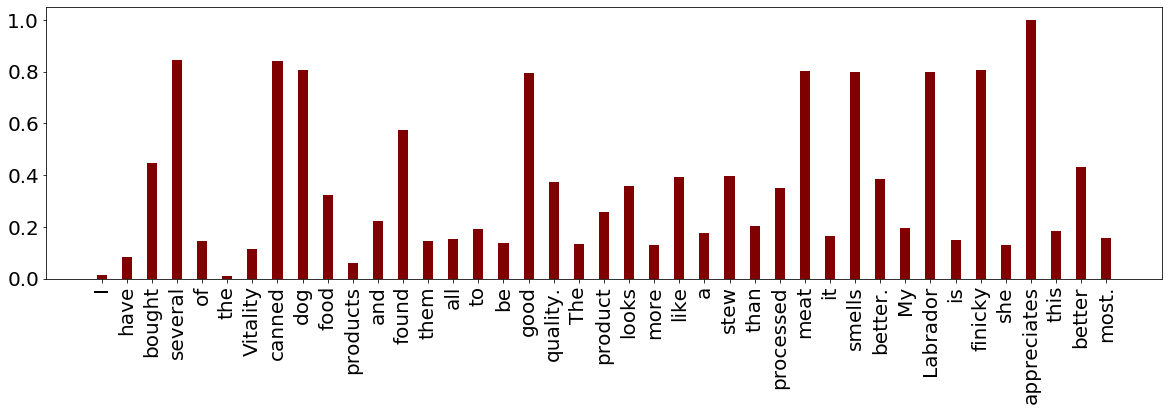

In [17]:
getPlot(review, importance)

The above figure shows the importance of each word from the original customer review in determining the words in the machine-generated summary. The importance score is calculated based on the average attention score (over all words in the summary).